In [1]:
import os.path
import sys 
print("Python %s.%s.%s"%sys.version_info[:3])
import scipy.stats
import emcee
print("emcee version", emcee.__version__)
from IPython.display import display, HTML
import numpy as np
%config InlineBackend.figure_format ='retina'
print(os.getcwd() + "\n")

Python 3.6.4
emcee version 2.2.1
/Users/Isabel/Documents/emcee



# Parameter estimation with emcee 

## Initializing data 

Data created from the following function, 

\begin{equation*}
y(x1,x2) = \int^{x1}_0 \textrm{sin}(A\zeta + Bx_2)(C\zeta^2 + ln(Dx_2)) d\zeta.
\end{equation*}

The given dataset contains data for $x1$, $x2$, $y$, and $\sigma_y$ (the standard error in y). Guesses for the four parameters are obtained using a random number between zero and five. 

In [2]:
#import data
data = np.loadtxt( '/Users/Isabel/Documents/emcee/fake2.dat' )

In [3]:
from matplotlib import pyplot as plt
np.random.seed(10)

var1 = data[0:,0]
var2 = data[0:,1]
var3 = data[0:,2]
var4 = data[0:,3]

x1 = np.copy(var1)
x2 = np.copy(var2)
y = np.copy(var3)
yerr = np.copy(var4)

a_approx = np.random.randint(1,5)
b_approx = np.random.randint(1,5)
c_approx = np.random.randint(1,5)
d_approx = np.random.randint(1,5)

print("Guesses:")
print("a = {0:0.3f}".format(a_approx))
print("b = {0:0.3f}".format(b_approx))
print("c = {0:0.3f}".format(c_approx)) 
print("d = {0:0.3f}".format(d_approx)) 

Guesses:
a = 2.000
b = 2.000
c = 1.000
d = 4.000


## Getting a feel for the data  

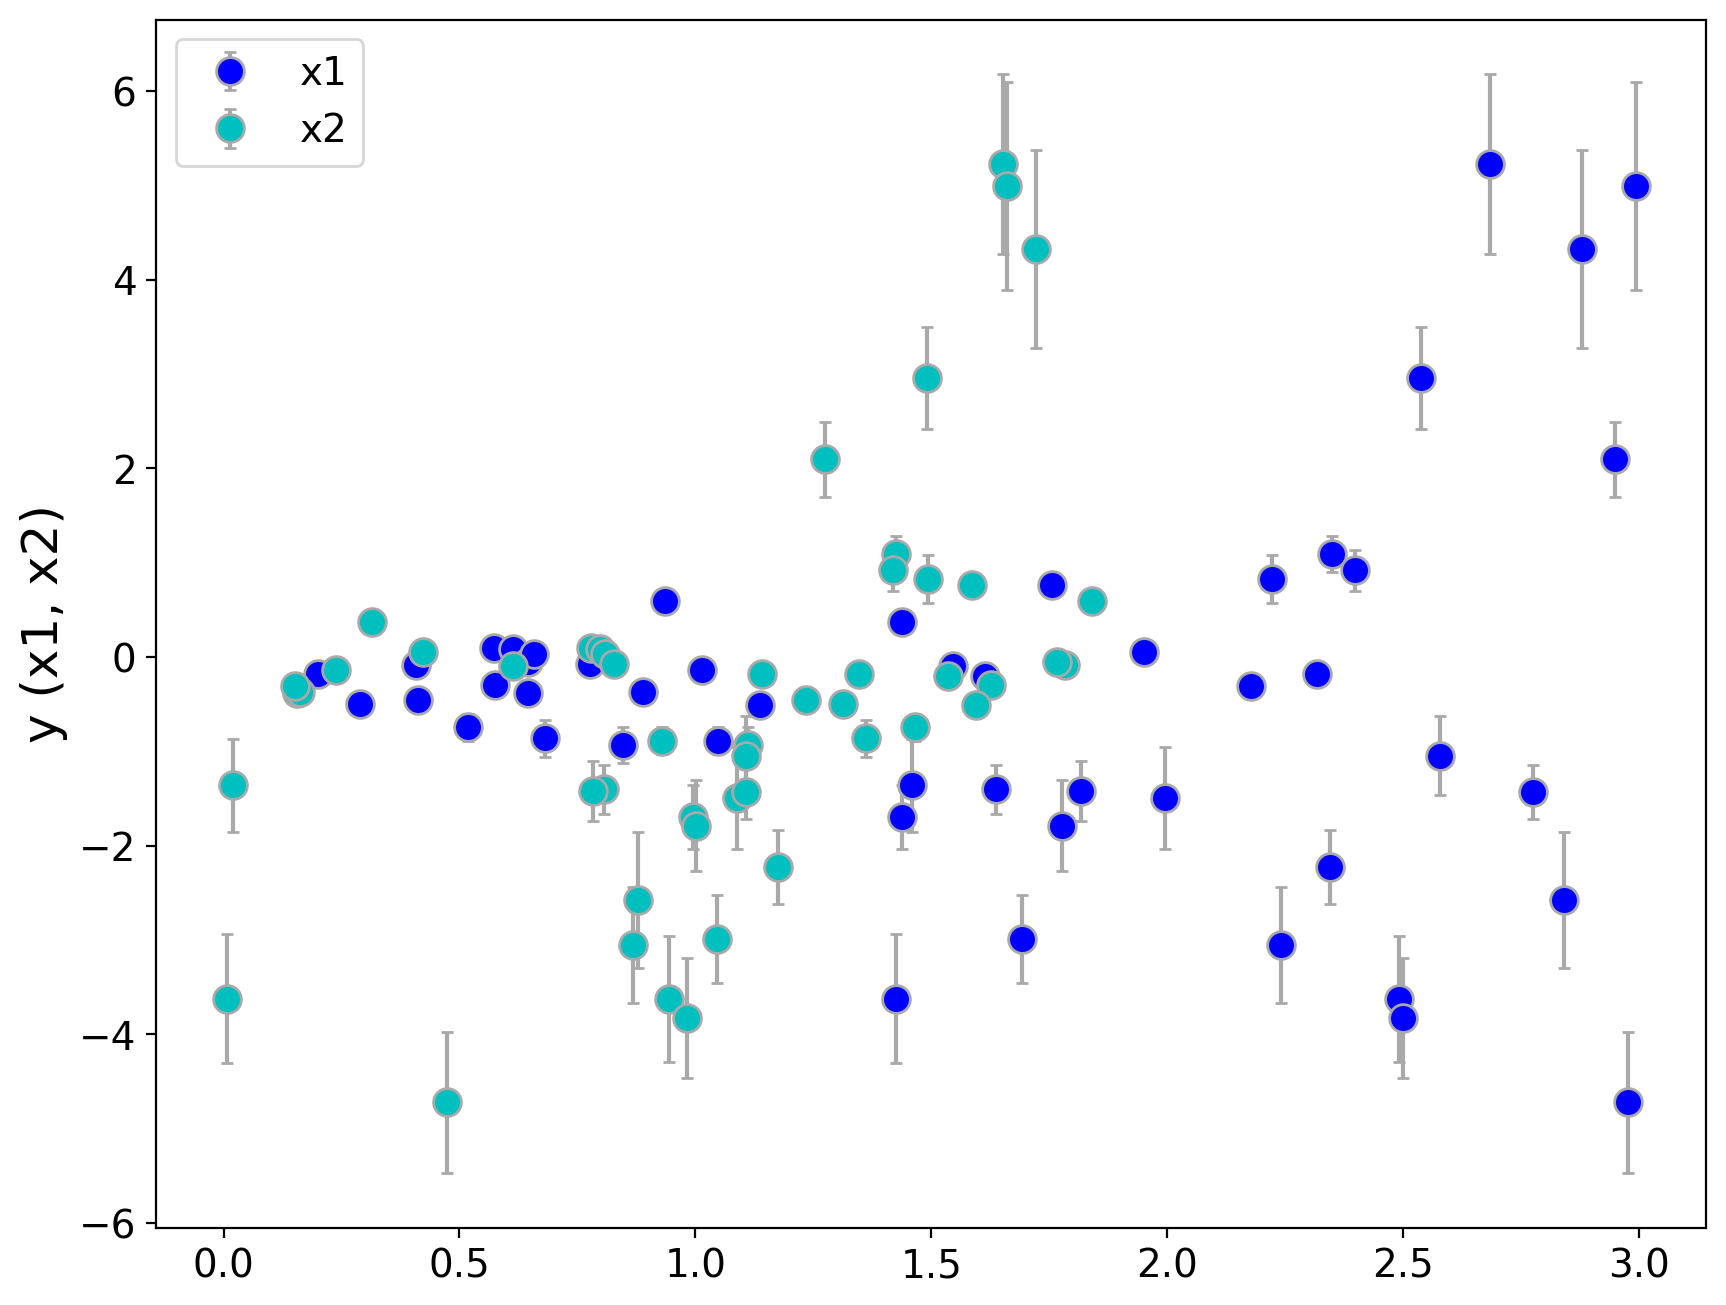

In [4]:
plt.figure(figsize=(10,8), dpi = 100)
plt.errorbar(x1,y,yerr=yerr, fmt=".b", markersize = 20, markeredgecolor = 'darkgrey', ecolor='darkgrey', capsize=2, elinewidth=1.5, markeredgewidth=1, alpha = 1)
plt.errorbar(x2,y,yerr=yerr, fmt=".c", markersize = 20, markeredgecolor = 'darkgrey', ecolor='darkgrey', capsize=2, elinewidth=1.5, markeredgewidth=1)

plt.legend(["x1", "x2"], fontsize=14)
#plt.xlabel("x", fontsize= 18)
plt.ylabel("y (x1, x2)", fontsize= 18, rotation = 90)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

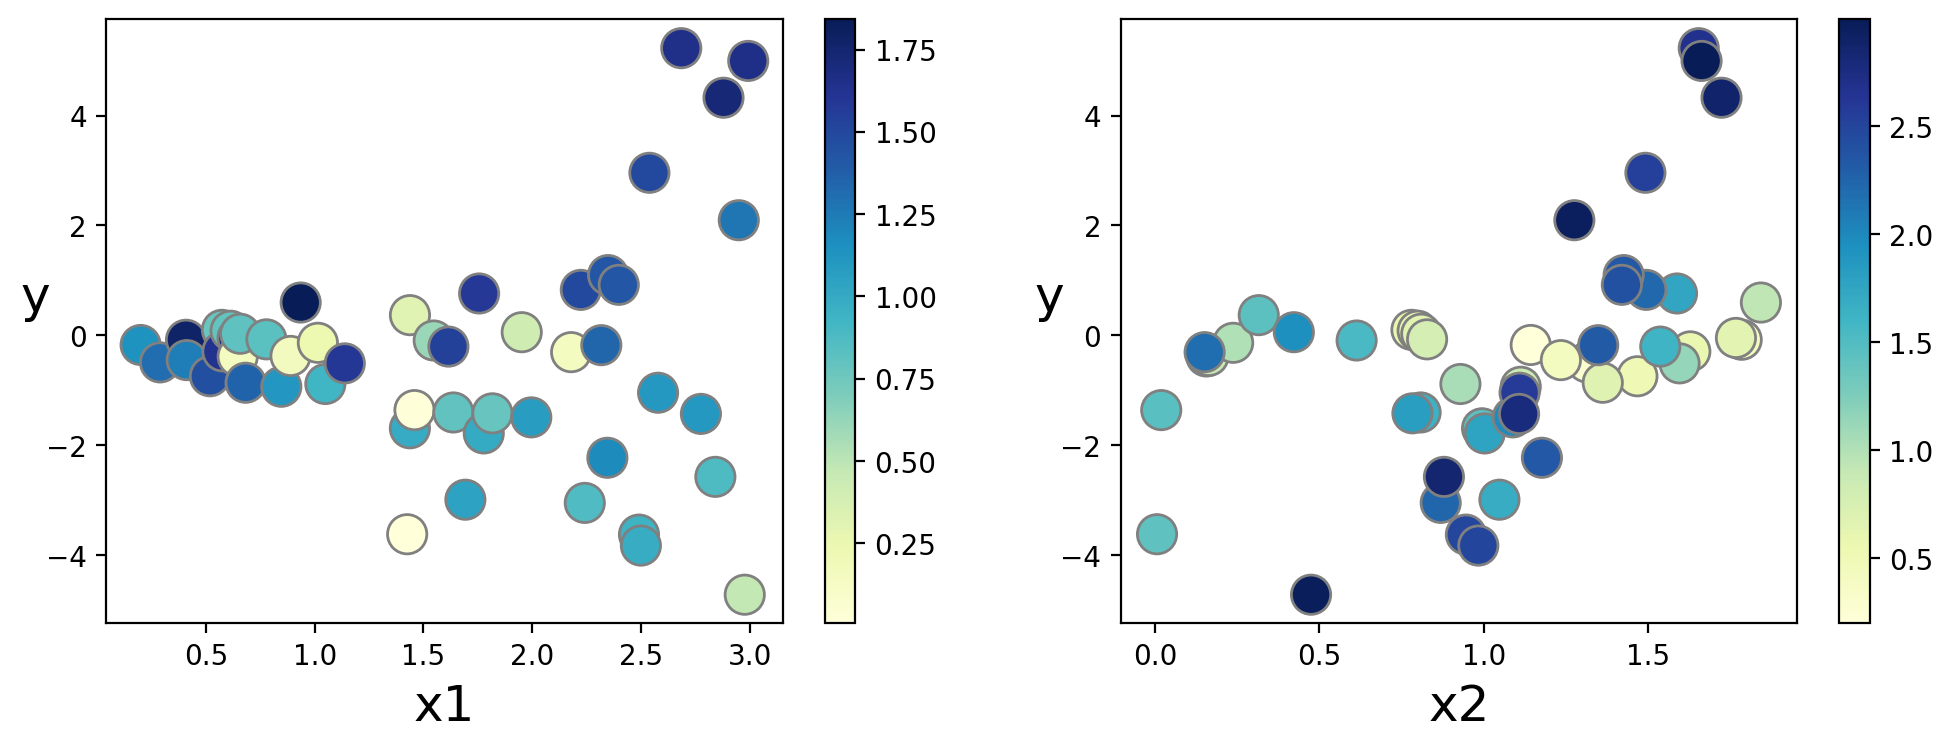

In [5]:
cm = plt.cm.get_cmap('YlGnBu')
plt.figure(figsize=(12,4), dpi = 100)
plt.subplot(1,2,1)
plt.scatter(x1, y, c=x2, s=200, marker='o', edgecolor = 'gray', cmap=cm)
plt.colorbar()
plt.xlabel('x1', fontsize = 18)
plt.ylabel('y', fontsize = 18, rotation = 0)

plt.subplot(1,2,2)
plt.scatter(x2, y, c=x1, s=200, marker='o', edgecolor = 'gray', cmap=cm)
plt.colorbar()
plt.xlabel('x2', fontsize = 18)
plt.ylabel('y', fontsize = 18, rotation = 0)

plt.show()

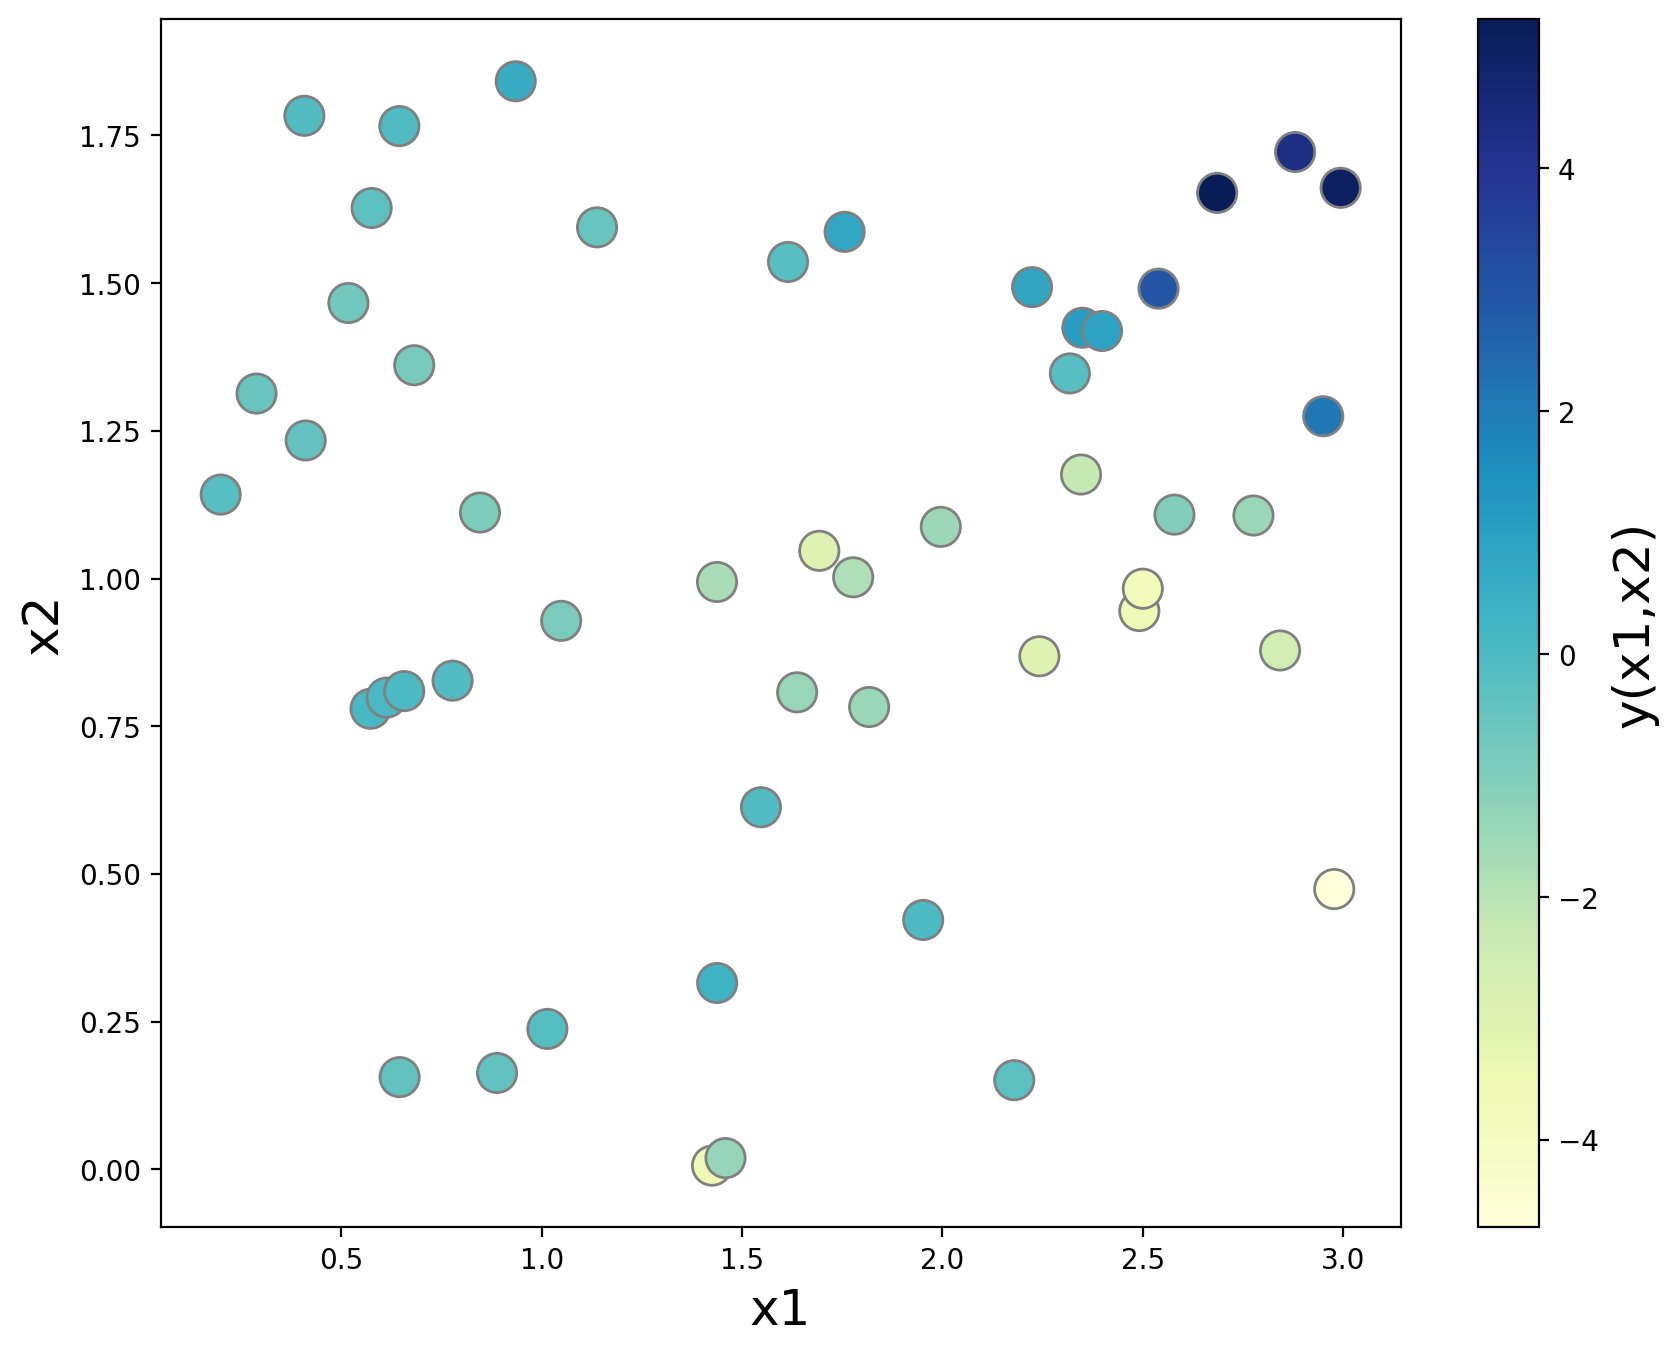

In [6]:
fig, ax = plt.subplots(figsize=(10,8), dpi = 100)
cm = plt.cm.get_cmap('YlGnBu')
scat = ax.scatter(x1, x2, c=y, s=200, marker='o', edgecolor = 'gray', cmap=cm)
cb = plt.colorbar(scat)
cb.set_label('y(x1,x2)', fontsize = 18)
plt.xlabel('x1', fontsize = 18)
plt.ylabel('x2', fontsize = 18, rotation = 90)
plt.show()

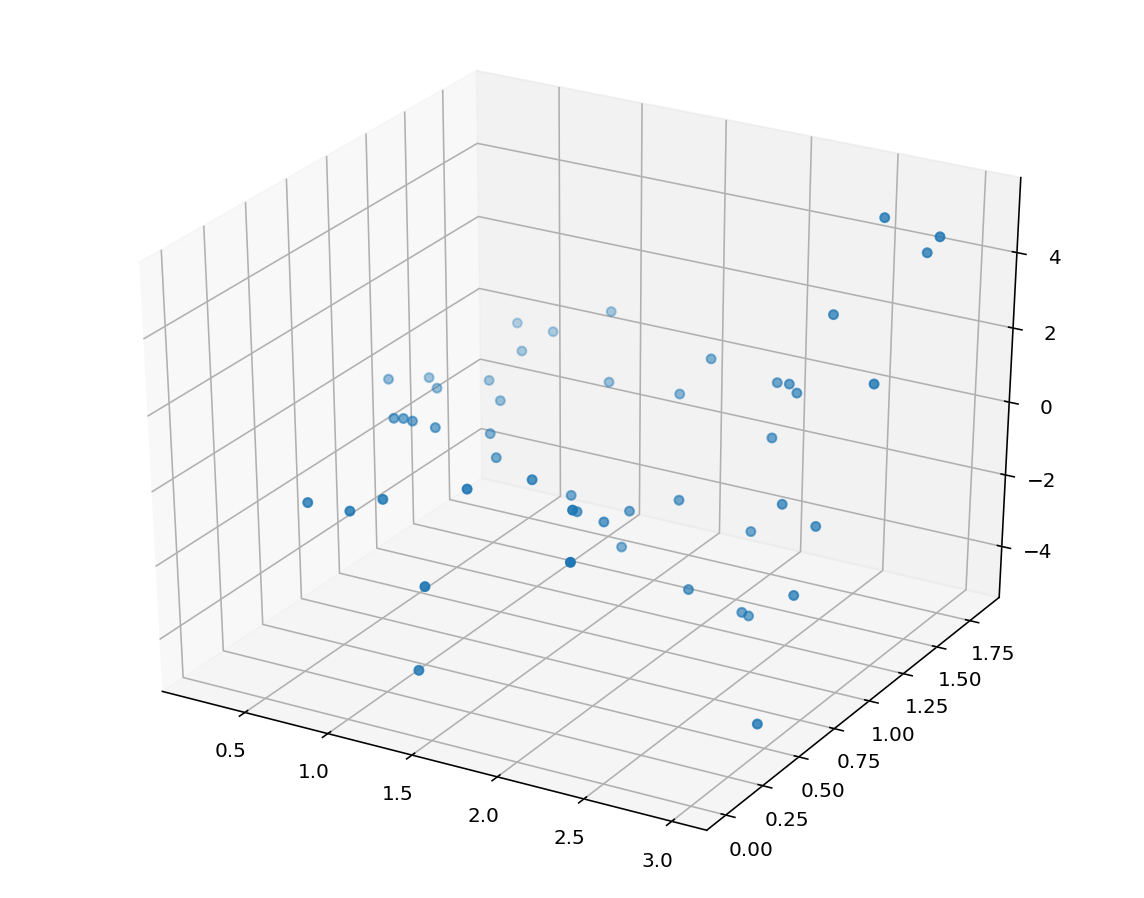

In [7]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y)
plt.show()

## Using sympy to evaluate the integral 

Sympy enables the user to evaluate an integral symbolically, then turn it into a numpy function which can then be used by the emcee module. 

In [8]:
import sympy as sym

x1, x2, a, b, c, d, x = sym.symbols('x1, x2, a, b, c, d, x')
f = sym.sin(a*x + b * x2) * (c*x**2 + sym.ln(d*x2))  
yx1x2 = sym.integrate(f, (x, 0, x1))  
 
f_mod = sym.lambdify( (x1, x2, a, b, c, d, x), yx1x2, 'numpy')

## emcee: Maximum likelihood, corner plot, projection of posterior samples

In [9]:
def log_prior(theta): 
    a, b, c, d = theta
    if 0.0 < a < 5.0 and 0.0 < b < 5.0 and 0.0 < c < 5.0 and 0.0 < d < 5.0: 
        return 0.0
    return -np.inf

In [10]:
def log_likelihood(theta, x1, x2, y, yerr, f_mod): 
    a, b, c, d = theta
    model =  f_mod
    return -0.5 * np.sum(((y-model(x1, x2, a ,b, c, d, x))**2/yerr**2))

In [11]:
def log_probability(theta, x1, x2, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr, f_mod)

In [12]:
import emcee 
from scipy.optimize import minimize

x1 = np.copy(var1)
x2 = np.copy(var2)
y = np.copy(var3)
yerr = np.copy(var4)

initial = np.array([a_approx, b_approx, c_approx, d_approx])
n11 = lambda *args: -log_likelihood(*args)
soln = minimize(n11, initial, args=(x1, x2, y, yerr, f_mod), method = 'Nelder-Mead', tol = 1e-6)
print(soln)
pos = soln.x + 1e-4 * np.random.randn(100,4)
nwalkers, ndim = pos.shape

a_ml, b_ml, c_ml, d_ml = soln.x

if soln.success == False: 
    exit() 

 final_simplex: (array([[ 1.25409929,  3.2981289 ,  0.53795329,  3.02431485],
       [ 1.25409934,  3.29812887,  0.53795307,  3.02431479],
       [ 1.25409926,  3.29812894,  0.5379534 ,  3.02431455],
       [ 1.25409949,  3.29812886,  0.53795302,  3.02431584],
       [ 1.25409934,  3.29812884,  0.53795348,  3.02431502]]), array([ 24.4692381,  24.4692381,  24.4692381,  24.4692381,  24.4692381]))
           fun: 24.469238097118481
       message: 'Optimization terminated successfully.'
          nfev: 314
           nit: 181
        status: 0
       success: True
             x: array([ 1.25409929,  3.2981289 ,  0.53795329,  3.02431485])


In [13]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x1, x2, y, yerr))
sampler.run_mcmc(pos, 5000)

(array([[ 1.24862961,  3.29784106,  0.54341061,  2.95918924],
        [ 1.25509121,  3.29467693,  0.55071208,  3.03984018],
        [ 1.23775803,  3.30440576,  0.55632419,  2.92959409],
        [ 1.27118238,  3.29443437,  0.51958982,  3.15498861],
        [ 1.285782  ,  3.28720771,  0.48848782,  3.16534908],
        [ 1.25732922,  3.301315  ,  0.53386581,  3.05184982],
        [ 1.24912912,  3.28836639,  0.58252181,  2.87209856],
        [ 1.24384623,  3.29840659,  0.57265453,  2.97627235],
        [ 1.24546587,  3.29663563,  0.54585625,  2.94199585],
        [ 1.26272591,  3.29762843,  0.49238875,  3.09561043],
        [ 1.2588795 ,  3.29153781,  0.54013795,  3.05332772],
        [ 1.25485693,  3.30522784,  0.53869922,  3.09652403],
        [ 1.24984243,  3.29601696,  0.56827874,  2.97977566],
        [ 1.24951351,  3.29837284,  0.57118426,  2.95609666],
        [ 1.27863513,  3.2894713 ,  0.51276655,  3.13172062],
        [ 1.23553622,  3.3059009 ,  0.55151676,  2.92903839],
        

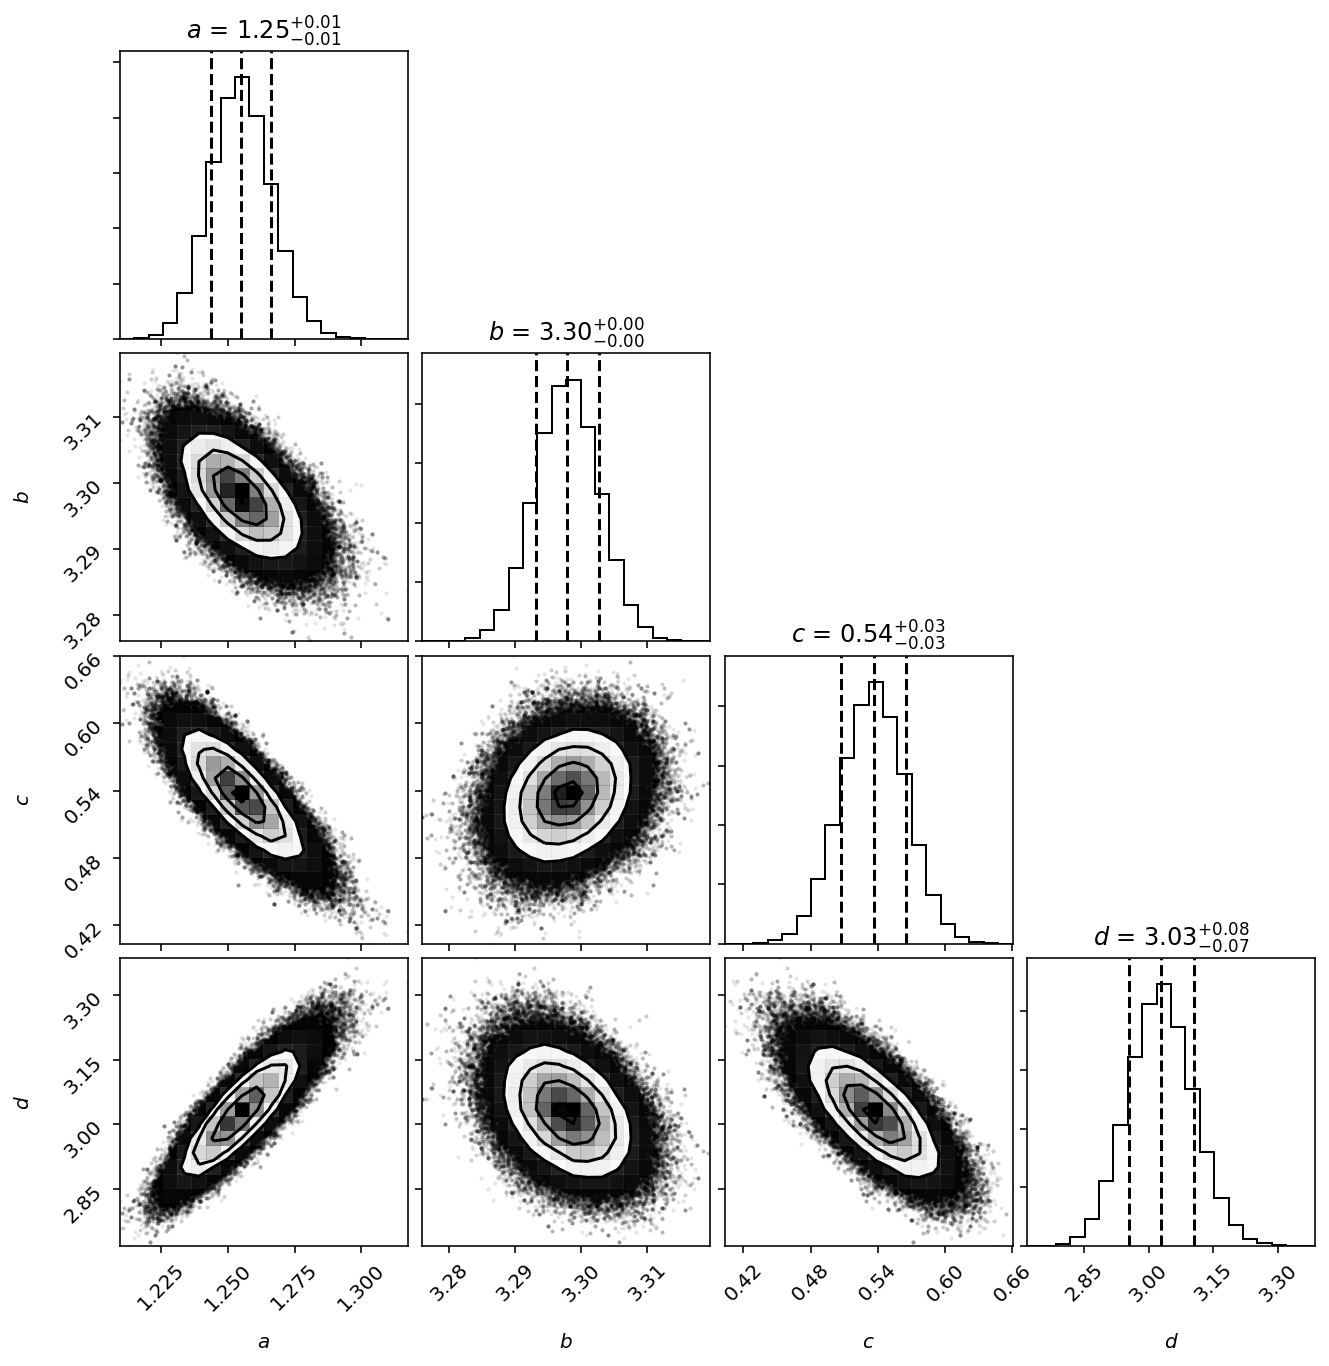

In [14]:
samples = sampler.chain[:, :, :].reshape((-1,ndim))

import corner
fig = corner.corner(samples, labels=["$a$", "$b$", "$c$", "$d$","$\ln\,f$"], quantiles=[0.16, 0.5, 0.84], show_titles=True, figsize=(10,10))
fig.savefig("triangle.png")

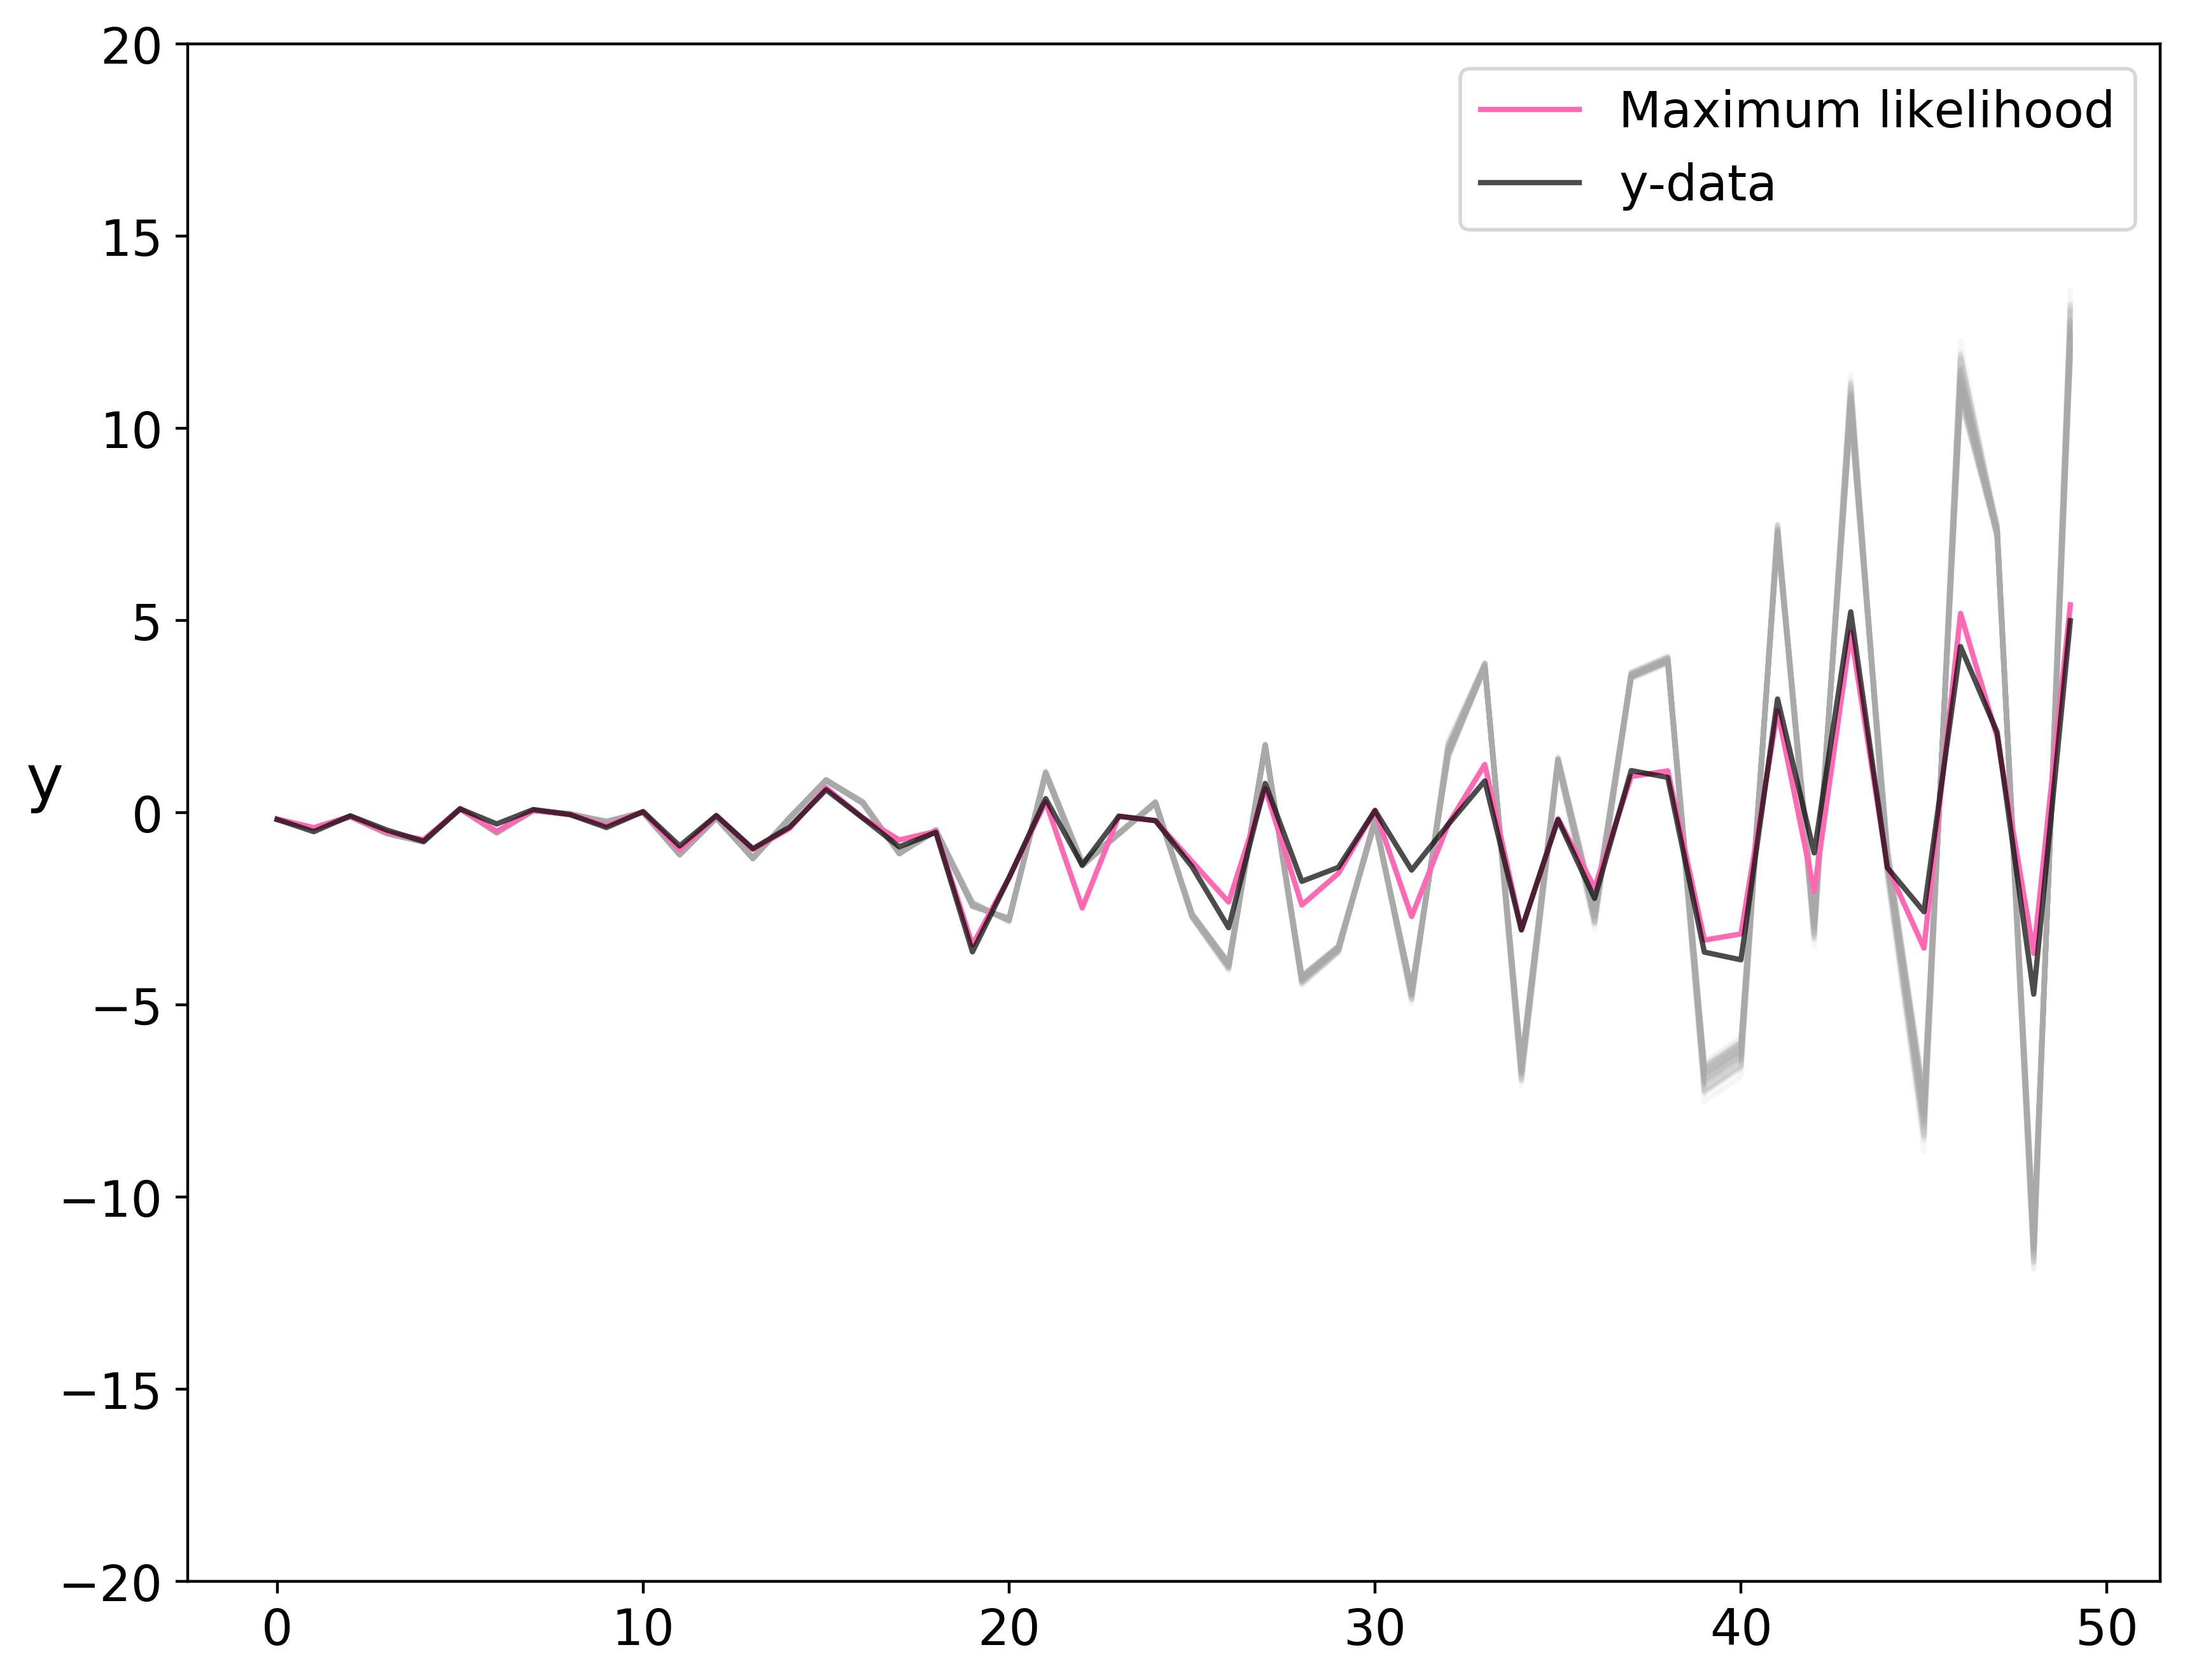

In [21]:
a_list = []
b_list = []
c_list = []
d_list = []

for a, b, c, d in samples[np.random.randint(len(samples), size=100)]:
    a_list.append(a)
    b_list.append(b)
    c_list.append(c)
    d_list.append(d)

plt.figure(figsize=(10,8), dpi = 200)
for i in range(len(x1)): 
    plt.plot(f_mod(x1, x2, a_list[i],b_list[i],c_list[i],d_list[i], x), color="darkgrey", alpha=0.1)

plt.plot(f_mod(x1, x2, a_ml,b_ml, c_ml, d_ml, x), "hotpink", label="Maximum likelihood")
plt.plot(y, 'k',  label="y-data", alpha = 0.7)
plt.legend(fontsize=14)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.ylim(-20,20)
plt.show()

In [16]:
samples[:,2] = np.exp(samples[:,2])
a_mcmc, b_mcmc, c_mcmc, d_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

In [17]:
print("MCMC estimates:")
print("a = ",a_mcmc[0], ",", "+", a_mcmc[1], ",", "-", a_mcmc[2]) 
print("b = ",b_mcmc[0], ",", "+", b_mcmc[1], ",", "-", b_mcmc[2]) 
print("c = ",c_mcmc[0], ",", "+", c_mcmc[1], ",", "-", c_mcmc[2]) 
print("d = ",d_mcmc[0], ",", "+", d_mcmc[1], ",", "-", d_mcmc[2]) 
print("---------------------")
print("Initial guesses:")
print("a = {0:0.3f}".format(a_approx))
print("b = {0:0.3f}".format(b_approx))
print("c = {0:0.3f}".format(c_approx)) 
print("d = {0:0.3f}".format(d_approx)) 
print("---------------------")
print("Maximum likelihood estimates:")
print("a = {0:0.3f}".format(a_ml))
print("b = {0:0.3f}".format(b_ml))
print("c = {0:0.3f}".format(c_ml)) 
print("d = {0:0.3f}".format(d_ml)) 


MCMC estimates:
a =  1.254796175 , + 0.0115766820425 , - 0.011007399297
b =  3.29792595341 , + 0.00479657888896 , - 0.00477471395679
c =  1.70966847918 , + 0.0495651423673 , - 0.0492909470157
d =  3.02744177214 , + 0.0763126207275 , - 0.0740768907608
---------------------
Initial guesses:
a = 2.000
b = 2.000
c = 1.000
d = 4.000
---------------------
Maximum likelihood estimates:
a = 1.254
b = 3.298
c = 0.538
d = 3.024
